### Chain Using LangGraph
In this section we will see how we can build a simple chain using Langgraph that uses 4 important concepts

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes 

In [1]:
"""
STEP 3: Environment Setup
Load API credentials securely from environment variables.
"""

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get Google API key with error handling
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY not found in environment variables")

print("✓ API keys loaded successfully")

✓ API keys loaded successfully


In [3]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

# Initialize Google embeddings model for vector representation
embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001", 
    google_api_key=GOOGLE_API_KEY
)


# Initialize Google's Gemini model for response generation
llm = ChatGoogleGenerativeAI(
    google_api_key=GOOGLE_API_KEY,
    model="gemini-2.0-flash",    # Latest fast Gemini model for quick reranking
    temperature=0,               # Deterministic output for consistency in ranking
    max_tokens=None,            # Use model default token limit
    timeout=None,               # No timeout limit for ranking requests
    max_retries=2,              # Retry failed requests twice
)

print("✓ Gemini model initialized for reranking")

/home/bjit/Desktop/Storage01/SelfDevelopment/Rag_Course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Gemini model initialized for reranking


#### How to use chat messages as our graph state
##### Messages

We can use messages which can be used to capture different roles within a conversation.
LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage.
These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have these important components.

- content - content of the message
- name - Specify the name of author
- response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)



In [4]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Saib"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming language",name="Saib"))

for message in messages:
    message.pretty_print()



================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: Saib

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: Saib

I want to learn python programming language


### Chat Models

We can use the sequence of message as input with the chatmodels using LLM's and OPENAI.

In [5]:
result=llm.invoke(messages)

In [6]:
result.response_metadata

{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'safety_ratings': []}

In [10]:
print(result.content)

Okay, great choice! Python is a fantastic language for beginners and experienced programmers alike. It's versatile and used in many fields. Here's a structured approach to learning Python, along with resources and tips:

**1. Set Up Your Environment:**

*   **Install Python:** Download the latest version of Python from the official website: [https://www.python.org/downloads/](https://www.python.org/downloads/)  Make sure to check the box that says "Add Python to PATH" during the installation process. This makes it easier to run Python from your command line.
*   **Choose a Code Editor or IDE (Integrated Development Environment):**
    *   **Beginner-Friendly:**
        *   **Thonny:**  A simple and easy-to-use IDE specifically designed for beginners. It comes with Python pre-installed.
        *   **IDLE:**  The default IDE that comes with Python. It's basic but functional.
    *   **More Advanced (but still good for beginners):**
        *   **Visual Studio Code (VS Code):**  A very p

### Tools
Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools.

Whenever a query is asked the model can choose to call the tool and this query is based on the 
natural language input and this will return an output that matches the tool's schema

In [11]:
def add(a:int,b:int)-> int:
    """ Add a and b
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int
    """
    return a+b

In [12]:
llm

ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), temperature=0.0, max_retries=2, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7d9a99526090>, default_metadata=())

In [13]:
### Binding tool with llm

llm_with_tools=llm.bind_tools([add])

tool_call=llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 2",name="Saib")])

In [14]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2.0, 'b': 2.0},
  'id': '6f0b7146-c65c-4f68-8e75-8143d0a992f0',
  'type': 'tool_call'}]

In [25]:
tool_call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"a": 2.0, "b": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--c5284f7d-9618-49ed-9d74-eaef36f936d6-0', tool_calls=[{'name': 'add', 'args': {'a': 2.0, 'b': 2.0}, 'id': '6f0b7146-c65c-4f68-8e75-8143d0a992f0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 38, 'output_tokens': 5, 'total_tokens': 43, 'input_token_details': {'cache_read': 0}})

### Using messages as state

In [15]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    message:list[AnyMessage]

#### Reducers
Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As our graph runs, we want to append messages to our messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [16]:
from langgraph.graph.message import add_messages
from typing import Annotated
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

### Reducers with add_messages

In [17]:
initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Saib"))
initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Saib')]

In [18]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [19]:
### Reducers add_messages is to append instead of override
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='c372c39c-d639-456b-af1e-98da7f62bb2a'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Saib', id='bba56e15-de9a-4ea1-81e5-7f1cb9691b70'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='3d9a1b47-338d-4b17-a83c-ade7b34b10e4')]

In [20]:
## chatbot node functionality
def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

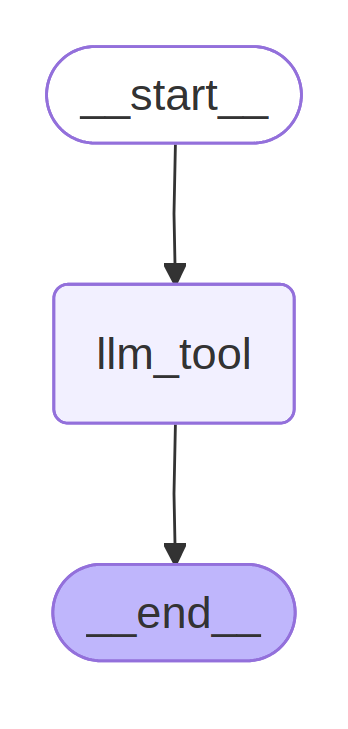

In [21]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.graph import MermaidDrawMethod 

import nest_asyncio
nest_asyncio.apply()

builder=StateGraph(State)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [22]:
## invocation

messages=graph.invoke({"messages":"What is 2 plus 9"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 9
================================== Ai Message ==================================
Tool Calls:
  add (d0c985c2-2183-4653-987a-71a70bb0530a)
 Call ID: d0c985c2-2183-4653-987a-71a70bb0530a
  Args:
    a: 2.0
    b: 9.0


In [24]:
messages

{'messages': [HumanMessage(content='What is 2 plus 9', additional_kwargs={}, response_metadata={}, id='a83a1ecf-be93-4ced-b75f-59ea557c29e3'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"a": 2.0, "b": 9.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--2e21b41a-7bd0-4f1a-82f5-afea3d7b5bbe-0', tool_calls=[{'name': 'add', 'args': {'a': 2.0, 'b': 9.0}, 'id': 'd0c985c2-2183-4653-987a-71a70bb0530a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 38, 'output_tokens': 5, 'total_tokens': 43, 'input_token_details': {'cache_read': 0}})]}

In [23]:
tools=[add]

In [29]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder=StateGraph(State)

## Add nodes

builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))

## Add Edge
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)
builder.add_edge("llm_tool",END)


graph_builder = builder.compile()



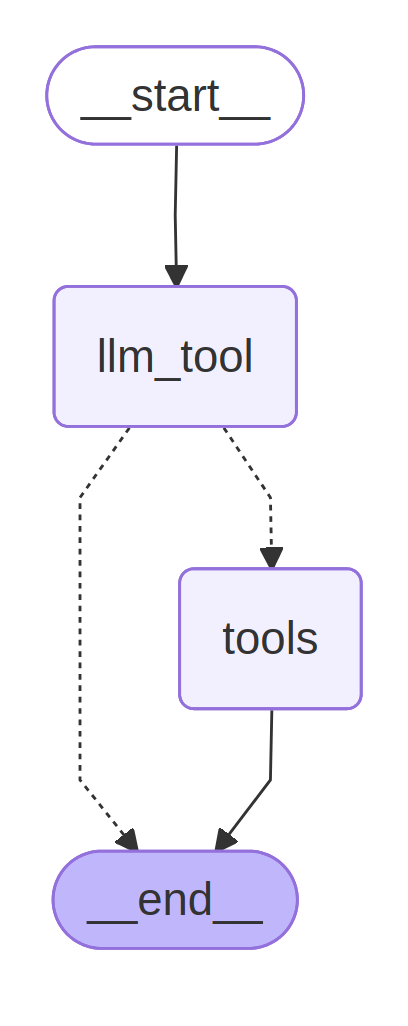

In [30]:
from langchain_core.runnables.graph import MermaidDrawMethod 
display(Image(graph_builder.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [32]:
## invocation

messages=graph_builder.invoke({"messages":"What is 2 plus 9"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 9
================================== Ai Message ==================================
Tool Calls:
  add (499eb1b8-7b41-4722-a9bd-df3091031d50)
 Call ID: 499eb1b8-7b41-4722-a9bd-df3091031d50
  Args:
    a: 2.0
    b: 9.0
================================= Tool Message =================================
Name: add

11


In [33]:
messages=graph_builder.invoke({"messages":"What Machine Learning"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What Machine Learning
================================== Ai Message ==================================

I am designed to perform addition operations. I cannot provide information about Machine Learning.
